There are many cases where the transfer coefficient in the convection-diffusion equations is a function of the independent variable. This makes the PDE nonlinear. While working on my thesis, I realized that it is not that difficult to use the Taylor expansion to linearize the nonlinear terms in a PDE. Here, I'm going to give a simple example. In another post, I will explain how the same idea can be used to numerically solve the Buckley-Leverett equation.

## The PDE
I'm going to try a simple one here. I say try because I'm actually making it up right now. The equation reads $$\frac{\partial\phi}{\partial t}+\nabla . (-D\nabla \phi) =0$$ where $$D=D_0(1+\phi^2).$$ It means that the diffusion coefficient is increased when the concentration of the solute increases.  
To linearize this equation, I assume that $\phi$ and $\nabla \phi$ are independent variables. Using Taylor expansion around a point $\phi_0$, we can obtain the following general form: $$f\left(\phi\right)\nabla \phi=f\left(\phi_{0}\right)\nabla \phi+\nabla \phi_{0}\left(\frac{\partial f}{\partial \phi}\right)_{\phi_{0}}\left(\phi-\phi_{0}\right).$$ In our case, this equation simplifies to $$D_0(1+\phi^2)\nabla \phi=D_0(1+\phi_0^2)\nabla \phi+2D_0\phi_0\nabla \phi_0(\phi-\phi_0).$$ Putting back everythin together, we obtain this linearized form for our PDE $$\frac{\partial\phi}{\partial t}+\nabla.(-D_{0}(1+\phi_{0}^{2})\nabla\phi)+\nabla.(-2D_{0}\phi_{0}\nabla\phi_{0}\phi)=\nabla.(-2D_{0}\phi_{0}\nabla\phi_{0}\phi_{0}).$$ Don't freak out! This equation is actually quite simple. By linearizing, we have added a linear convection term to our nonlinear diffusion equation. This equation is still an approximation of the real PDE. We have to solve the linear equation for $\phi$ by initializing $\phi_0$. Then, we assign the new value of $\phi$ to $\phi_0$ until it converges to a solution. The question that still remains is that "is this really a good idea to make a diffusion equation more complicated by adding a convection term to it?".  


<!-- TEASER_END -->


## The solution procedure
Solving this equation is done in two loops. The outer loop is for the time steps, and the inner loop is for the nonlinear equation. We will assemple an equation which looks like this: $$\text{Transient}(\Delta t,\phi)-\text{Diffusion}(D(\phi_0),\phi)+\text{Convection}(\mathbf{u}(\phi_0),\phi)=\text{divergence}(D(\phi_0), \nabla\phi_0)$$

## Implementation in JFVM
Here, I'll implement the procedure in [JFVM](http://github.com/simulkade/JFVM.jl). The same procedure can be done in [FVtool](http://github.com/simulkade/FVTool).

In [7]:
using JFVM, JFVMvis, PyPlot

In [8]:
function diffusion_newton()
L = 1.0 # domain length
Nx = 100 # number of cells
m = createMesh1D(Nx, L) # create a 1D mesh
D0 = 1.0 # diffusion coefficient constant
# Define the diffusion coefficientand its derivative
D(phi) = D0*(1.0+phi.^2)
dD(phi) = 2.0*D0*phi
# create boundary condition
BC = createBC(m)
BC.left.a .= 0.0
BC.left.b .= 1.0
BC.left.c .= 5.0
BC.right.a .= 0.0
BC.right.b .= 1.0
BC.right.c .= 0.0
Mbc, RHSbc = boundaryConditionTerm(BC)
# define the initial condition
phi0 = 0.0 # initial value
phi_old = createCellVariable(m, phi0, BC) # create initial cells
phi_val = copyCell(phi_old)
# define the time steps
dt = 0.001*L*L/D0 # a proper time step for diffusion process
for i=1:10
    err=100
    Mt, RHSt = transientTerm(phi_old, dt)
    while err>1e-10
        # calculate the diffusion coefficient
        Dface= harmonicMean(cellEval(D,phi_val))
        # calculate the face value of phi_0
        phi_face= linearMean(phi_val)
        # calculate the velocity for convection term
        u= faceEval(dD, phi_face)*gradientTerm(phi_val)
        # diffusion term
        Mdif= diffusionTerm(Dface)
        # convection term
        Mconv= convectionTerm(u)
        # divergence term on the RHS
        RHSlin= divergenceTerm(u*phi_face)
        # matrix of coefficients
        M= Mt-Mdif-Mconv+Mbc
        # RHS vector
        RHS= RHSbc+RHSt-RHSlin
        # call the linear solver
        phi_new= solveLinearPDE(m, M, RHS)
        # calculate the error
        err= maximum(abs.(phi_new.value .- phi_val.value))
        # assign the new phi to the old phi
        phi_val=copyCell(phi_new)
    end
    phi_old= copyCell(phi_val)
    visualizeCells(phi_val)
end
    return phi_val
end

diffusion_newton (generic function with 1 method)

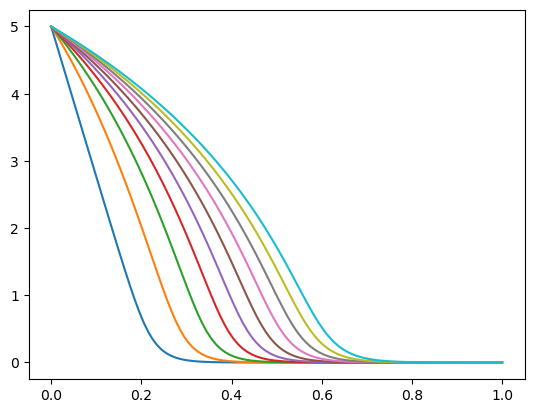

  0.047176 seconds (115.67 k allocations: 21.622 MiB)


In [10]:
@time phi_n=diffusion_newton();

The solution looks quite good. The diffusion coefficient is higher at higher concentrations, and it can be clearly observed in the above concentration profile (if you compare it with a diffusion problem with constant diffusion coefficient, in your head).
## Some questions
The convection term that appears after linearization of the problem has a velocity term, which reads $$\mathbf{u}(\phi_0)=−2.0D_0\phi_0\nabla\phi_0$$ I have written a function, called `gradientTerm` which gives you the value of the gradient on the cell faces. This gradient is multiplied by a term that needs to be averaged on each cell face. Here, I have calculated the arithmetic average of $\phi_0$ using a function called suprise suprise `linearMean`. This is of course one way of doing it. The other ways are `geometricMean`, `harmonicMean`, `upwindMean`, `tvdMean`, and `aritheticMean`. Here, we will discuss them.
## Averaging techniques for the face values in FVM
The following figure shows two neigbor cells with different length and values.  
![neighbor cells FVM](/averaging_pic.png)
The averaging terms that are used in JFVM are as follows:
### Linear mean
It is equivalent to a linear interpolation or the lever rule. It reads $$\phi_{face}=\frac{\Delta x_1\phi_2+\Delta x_2\phi_1}{\Delta x_1+\Delta x_2}$$
### Arithmetic mean
The value of each cell is weighted by its length: $$\phi_{face}=\frac{\Delta x_1\phi_1+\Delta x_2\phi_2}{\Delta x_1+\Delta x_2}$$
### Geometric mean
It reads $$\phi_{face}=\exp\left(\frac{\Delta x_1\log(\phi_1)+\Delta x_2\log(\phi_2)}{\Delta x_1+\Delta x_2}\right)$$
### Harmonic mean
It reads $$\phi_{face}=\frac{\Delta x_1+\Delta x_2}{\Delta x_1/\phi_1+\Delta x_2/\phi_2}$$
Note that if the value of one of the cells is zero, the geometric and harmonic means are also equal to zero.  
These methods have different applications for different ptoblems. We will discuss them in future posts.
## Direct substitution
The diffusion problem that we solved above can also be solved using a direct substitution method. Here, we don't use the derivatives and no linearization is required. The code is written here:

In [14]:
function diffusion_direct()
L = 1.0 # domain length
Nx = 100 # number of cells
m = createMesh1D(Nx, L) # create a 1D mesh
D0 = 1.0 # diffusion coefficient constant
# Define the diffusion coefficientand its derivative
D(phi) = D0*(1.0+phi.^2)
dD(phi) = 2.0*D0*phi
# create boundary condition
BC = createBC(m)
BC.left.a .= 0.0
BC.left.b .= 1.0
BC.left.c .= 5.0
BC.right.a .= 0.0
BC.right.b .= 1.0
BC.right.c .= 0.0
Mbc, RHSbc = boundaryConditionTerm(BC)
# define the initial condition
phi0 = 0.0 # initial value
phi_old = createCellVariable(m, phi0, BC) # create initial cells
phi_val = copyCell(phi_old)
# define the time steps
dt= 0.001*L*L/D0 # a proper time step for diffusion process
for i=1:10
    err=100
    Mt, RHSt = transientTerm(phi_old, dt)
    while err>1e-10
        # calculate the diffusion coefficient
        Dface= harmonicMean(cellEval(D, phi_val))
        # diffusion term
        Mdif= diffusionTerm(Dface)
        # matrix of coefficients
        M= Mt-Mdif+Mbc
        # RHS vector
        RHS= RHSbc+RHSt
        # call the linear solver
        phi_new= solveLinearPDE(m, M, RHS)
        # calculate the error
        err= maximum(abs.(phi_new.value .- phi_val.value))
        # assign the new phi to the old phi
        phi_val=copyCell(phi_new)
    end
    phi_old= copyCell(phi_val)
    visualizeCells(phi_val)
end
    return phi_val
end

diffusion_direct (generic function with 1 method)

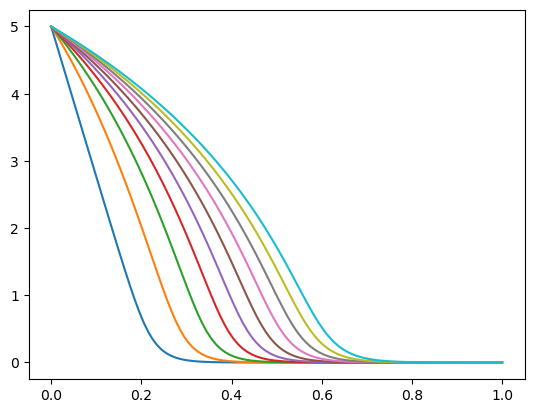

  0.070740 seconds (310.25 k allocations: 44.993 MiB, 7.68% gc time)


In [16]:
@time phi_ds=diffusion_direct();

## Show and compare the results
Here, I'm plotting the results of the Newton and the direct substitution methods for comparison.

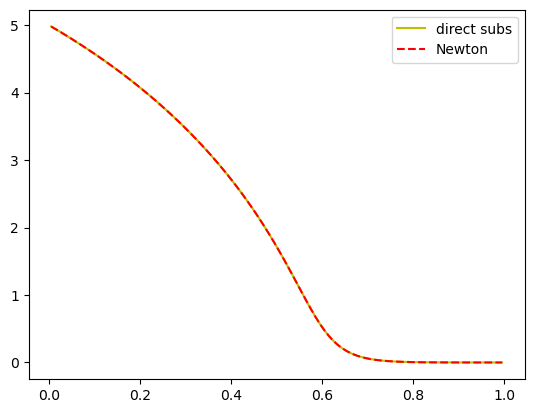

In [18]:
plot(phi_ds.domain.cellcenters.x, phi_ds.value[2:end-1], "y",
phi_n.domain.cellcenters.x, phi_n.value[2:end-1], "--r") 
legend(["direct subs", "Newton"]);

## Conclusion
The final results shows that we can linearize a nonlinear PDE, relatively easily and solve the equations using a linear PDE solver. No difference is observed between the final results of the direct substitution method (with no linearization) and the Newton method (with a linearized PDE). We can also observe that, as expected, the Newton method is relatively faster.

# Update
The same problem [implemented](https://github.com/simulkade/FVTool/blob/master/Examples/Tutorial/diffusionNonlinearTutorial.m) in Matlab: